In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)


In [78]:
df = pd.read_csv("./healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Tiền xử lý dữ liệu

In [79]:
df.drop(df[df["gender"] == "Other"].index, inplace=True)
df.drop(columns=["ever_married", "Residence_type", "work_type", "id"], inplace=True)

In [80]:
# Điền các giá trị NaN của bmi thành giá trị trung bình
df['bmi'].fillna(df['bmi'].mean(), inplace= True)
df['bmi'].isna().sum()

C:\Users\admin\AppData\Local\Temp\ipykernel_16620\199014536.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace= True)


0

#### Mã hóa các cột dữ liệu categorical

In [81]:
categories = ['smoking_status', 'gender']
enc = OneHotEncoder(handle_unknown='ignore')
for i in categories:
  values = enc.fit_transform(df[[i]]).toarray()
  columns = enc.categories_[0]
  for j in range(len(columns)):
    df[columns[j]] = values[:, j]
  df.drop([i],axis=1,inplace=True)

In [82]:
df_stroke = df[df['stroke']==1]
df_non_stroke = df[df['stroke']==0][:300]
df_train = pd.concat([df_stroke, df_non_stroke])
df_train 

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Unknown,formerly smoked,never smoked,smokes,Female,Male
0,67.0,0,1,228.69,36.60000,1,0.0,1.0,0.0,0.0,0.0,1.0
1,61.0,0,0,202.21,28.89456,1,0.0,0.0,1.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.50000,1,0.0,0.0,1.0,0.0,0.0,1.0
3,49.0,0,0,171.23,34.40000,1,0.0,0.0,0.0,1.0,1.0,0.0
4,79.0,1,0,174.12,24.00000,1,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
544,42.0,0,0,210.48,71.90000,0,0.0,0.0,1.0,0.0,0.0,1.0
545,18.0,0,0,70.34,24.20000,0,1.0,0.0,0.0,0.0,0.0,1.0
546,9.0,0,0,122.22,17.70000,0,1.0,0.0,0.0,0.0,0.0,1.0
547,26.0,0,0,75.29,22.60000,0,0.0,0.0,0.0,1.0,1.0,0.0


In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_train.drop(columns=['stroke']))
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['stroke'] = df_train['stroke']
df_pca

,PC1,PC2,stroke
0,109.811506,1.570235,1
1,82.510764,4.149199,1
2,-10.160674,-27.825821,1
3,50.407113,11.676991,1
4,56.946849,-17.347375,1
...,...,...,...
544,89.636903,22.851133,0
545,-54.026958,28.999095,0
546,-4.086280,45.131410,0
547,-48.105315,21.787960,0


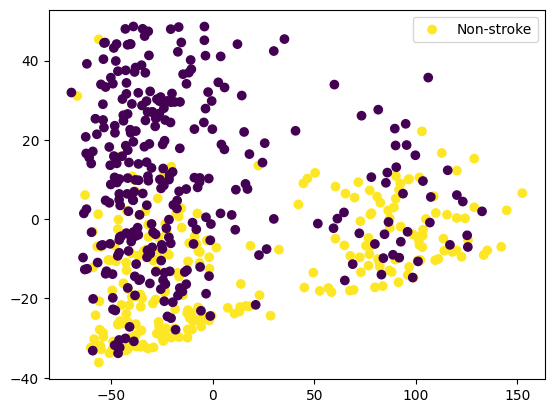

In [84]:
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['stroke'], cmap='viridis')
plt.legend(['Non-stroke', 'Stroke'])

In [85]:
# Chia dữ liệu thành 2 phần: Tập features và Outcome
X = df_train.drop(["stroke"], axis=1)
y = df_train["stroke"]

#### Chuẩn hóa dữ liệu

In [86]:
# Chia dữ liệu ra làm 2 phần train và test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

pd.DataFrame(X_train).to_csv('train_data.csv')

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

### Chọn model

#### Decision Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion="log_loss", max_depth = 7)
dtc.fit(X_train_scaled, y_train)
y_pred = dtc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.71        52
           1       0.76      0.66      0.70        58

    accuracy                           0.71       110
   macro avg       0.71      0.71      0.71       110
weighted avg       0.72      0.71      0.71       110



#### Support Vector Machine

In [88]:
from sklearn.svm import SVC
svc = SVC(C=1e2)
svc.fit(X_train_scaled, y_train)
y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        52
           1       0.80      0.74      0.77        58

    accuracy                           0.76       110
   macro avg       0.76      0.76      0.76       110
weighted avg       0.77      0.76      0.76       110



#### Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 900, criterion='log_loss',max_depth = 5)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82        52
           1       0.83      0.84      0.84        58

    accuracy                           0.83       110
   macro avg       0.83      0.83      0.83       110
weighted avg       0.83      0.83      0.83       110



In [90]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(C=1e4)
lgr.fit(X_train_scaled, y_train)
y_pred = lgr.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        52
           1       0.79      0.78      0.78        58

    accuracy                           0.77       110
   macro avg       0.77      0.77      0.77       110
weighted avg       0.77      0.77      0.77       110



#### K-Nearest Neighbour

In [91]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 12)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        52
           1       0.84      0.64      0.73        58

    accuracy                           0.75       110
   macro avg       0.76      0.75      0.74       110
weighted avg       0.77      0.75      0.74       110



In [92]:
import pickle

with open('model.pkl', 'wb') as f:
  pickle.dump(rfc, f)